**Implementation of Vanilla GANs model**

**Reference: https://arxiv.org/pdf/1406.2661.pdf**

**Original Code: https://github.com/goodfeli/adversarial**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

**The architecture of GAN consists of the following components:**

**Training Dataset$(x)$:**
The real data sample we train our Discriminator network to distinguish between real and fake data. The type of data you want to generate depends on your training dataset.

**Random Noise$(z)$:**
It acts as a starting point (raw input) to our Generator network. This noise gets transformed into fake data with the help of the Generator.

**Generator Network:**
It is a neural network that takes Random Noise$(z)$ as input and produces fake data$(x’)$ as an output. Its goal is to generate the data which can not be detected as fake data by the Discriminator network.

**Discriminator Network:**
It is also a neural network that takes data from the training dataset$(x)$ and fake data$(x’)$ as input and classifies them as real or fake.

**Iterative Training:**
As a GAN consists of two neural networks, the training phase simultaneously trains the Generator and Discriminator. We will see this in detail in the next part.

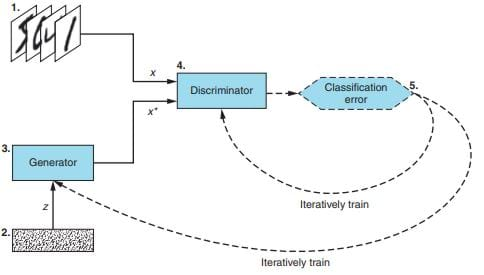

In [ ]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision.models as models
model_ft = models.vgg16(pretrained=True)
model_ft = model_ft.to(DEVICE)
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [ ]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
n_noise = 100

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [ ]:
preprocess_vgg16 = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 expects 224x224 images
    transforms.Normalize(mean=[0], std=[1]),
])

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [ ]:
batch_size = 128

In [ ]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
criterion = nn.BCELoss()
perceptual_loss = nn.MSELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [ ]:

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_vgg16 = x.repeat(1, 3, 1, 1)
        x_vgg16 = preprocess_vgg16(x_vgg16)
        with torch.no_grad():
          x_vgg16_output = model_ft(x_vgg16)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            gz_vgg16 = preprocess_vgg16(G(z).repeat(1, 3, 1, 1))
            with torch.no_grad():
              gz_vgg16_output = model_ft(gz_vgg16)
            G_loss = criterion(z_outputs, D_labels)+perceptual_loss(gz_vgg16_output,x_vgg16_output)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.4330254793167114, G Loss: 3.262172222137451
Epoch: 1/50, Step: 500, D Loss: 1.3050402402877808, G Loss: 2.922682046890259
Epoch: 2/50, Step: 1000, D Loss: 1.2184439897537231, G Loss: 3.1635794639587402
Epoch: 3/50, Step: 1500, D Loss: 1.13877272605896, G Loss: 3.1720311641693115
Epoch: 4/50, Step: 2000, D Loss: 1.1409474611282349, G Loss: 3.6104536056518555
Epoch: 5/50, Step: 2500, D Loss: 1.205482006072998, G Loss: 3.184216022491455
Epoch: 6/50, Step: 3000, D Loss: 1.141507625579834, G Loss: 3.493602752685547
Epoch: 7/50, Step: 3500, D Loss: 1.4271425008773804, G Loss: 2.656002998352051
Epoch: 8/50, Step: 4000, D Loss: 1.2346402406692505, G Loss: 2.975055456161499
Epoch: 9/50, Step: 4500, D Loss: 1.2058742046356201, G Loss: 3.0539331436157227
Epoch: 10/50, Step: 5000, D Loss: 1.2183541059494019, G Loss: 2.787553548812866
Epoch: 11/50, Step: 5500, D Loss: 1.2500789165496826, G Loss: 2.6104917526245117
Epoch: 12/50, Step: 6000, D Loss: 1.2422032356262207,

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

**Visualize Sample**

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [ ]:
# # Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')